In [67]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, Dropout
from tensorflow.keras.utils import plot_model
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
from keras_vggface.vggface import VGGFace
from keras.layers import Input

In [79]:
batch_size = 32
target_size = (224, 224)
input_shape=(224, 224, 3)
seed=1337
adam_lr = 0.001
FC = 2048
num_classes = 1
patience = 3
dense_dropout = 0
cnn_dropout = 0
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
epochs=5
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model_name = 'vggface_race.h5'

In [80]:
train_data = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_data = ImageDataGenerator( rescale = 1.0/255)

test_data = ImageDataGenerator( rescale = 1.0/255)

In [81]:
print("Training Data:")
# There are 7 different classes
train_generator = train_data.flow_from_directory('./races/Training',
                                                    batch_size =batch_size ,
                                                    class_mode = 'categorical',
                                                    seed=seed,
                                                    target_size = target_size )     

print("Validation Data:")
validation_generator =  validation_data.flow_from_directory( './races/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'categorical',
                                                          seed=seed,
                                                          target_size = target_size)

# print("Test Data:")
# test_generator = test_data.flow_from_directory('./races/Test',
#                                                           batch_size  = batch_size,
#                                                           class_mode  = 'categorical',
#                                                           seed=seed,
#                                                           target_size = target_size)

Training Data:
Found 47009 images belonging to 2 classes.
Validation Data:
Found 5811 images belonging to 2 classes.
Test Data:
Found 5820 images belonging to 2 classes.


In [82]:
# Based on VGG16 architecture -> old paper(2015)
vggface = VGGFace(model='vgg16') # or VGGFace() as default

In [83]:
vggface.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [84]:
model_old = Sequential()

for layer in vggface.layers[:-6]:
    model_old.add(layer)

for layer in model_old.layers:
    layer.trainable = False
    
model_old.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0         
                                                                 
 conv3_1 (Conv2D)            (None, 56, 56, 256)     

In [85]:
test_input = np.random.random((1, 224, 224, 3))  # Replace with your input shape
model_old.predict(test_input).shape

1/1 [==============================] - 0s 115ms/step


(1, 25088)

In [86]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    model_old,
    # Flatten(),
    Dense(FC, activation='relu'),
    Dropout(dense_dropout),
    Dense(num_classes, activation='sigmoid')
])
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (None, 25088)             14714688  
                                                                 
 dense_24 (Dense)            (None, 2048)              51382272  
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                                 
 dense_25 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 66,099,009
Trainable params: 51,384,321
Non-trainable params: 14,714,688
_________________________________________________________________


In [87]:
model.compile(optimizer=Adam(adam_lr),
              loss=loss
              ,metrics=metrics)

In [88]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint(model_name, )

es = EarlyStopping(verbose=verbose, patience=patience)

In [89]:
# Check the accuracy of the model before training
print("Accuracy before training")
score = model.evaluate(test_generator)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


# Train the model
print("Training the model")
# history = model.fit(train_generator,
#                     epochs = epochs,
#                     validation_data = validation_generator,
#                     steps_per_epoch = steps_per_epoch,
#                     validation_steps = validation_steps,
#                     callbacks = [lrd, mcp])
hist = model.fit(train_generator,
                  steps_per_epoch = train_generator.samples // batch_size,
                  validation_data = validation_generator, 
                  validation_steps = validation_generator.samples // batch_size,
                  epochs = epochs,
                  verbose = 1,
                  callbacks=[lrd, mcp])
# Save the model
print("Saving the model")
model.save(model_name)

# Check the accuracy of the model after training
print("Accuracy after training")
score = model.evaluate(test_generator)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Accuracy before training
182/182 [==============================] - 14s 72ms/step - loss: 0.6951 - accuracy: 0.4997
Test Loss: 0.6950876116752625
Test Accuracy: 0.4996563494205475
Training the model
Epoch 1/5
1469/1469 [==============================] - 320s 217ms/step - loss: 0.1375 - accuracy: 0.9532 - val_loss: 0.0839 - val_accuracy: 0.9710 - lr: 0.0010
Epoch 2/5
1469/1469 [==============================] - 301s 205ms/step - loss: 0.1202 - accuracy: 0.9609 - val_loss: 0.0887 - val_accuracy: 0.9701 - lr: 0.0010
Epoch 3/5
1469/1469 [==============================] - 304s 207ms/step - loss: 0.1159 - accuracy: 0.9611 - val_loss: 0.0845 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 4/5
1469/1469 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9625
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1469/1469 [==============================] - 303s 206ms/step - loss: 0.1115 - accuracy: 0.9625 - val_loss: 0.0956 - val_accuracy: 0.9698 - lr: 0.001

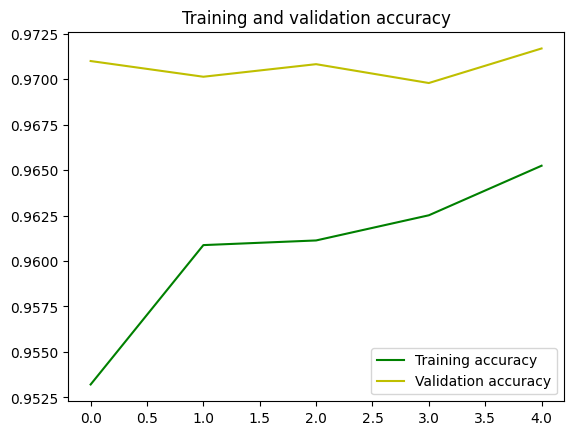

<Figure size 640x480 with 0 Axes>

In [90]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [92]:
model = load_model('vggface_gender_9744.h5')

In [110]:
# Loading the model and testing it on a sample image
print("Loading the model")
# model = load_model('model.h5')

print("Testing the model on a sample image")
# sample_img_path = './my_friends/cumali.jpeg'
sample_img_path = './my_friends/cemre2.jpg'
# sample_img_path = './my_friends/bayzan.jpg'
# sample_img_path = './my_friends/engin.jpg'
# sample_img_path = './my_friends/halimcan.jpg'
# sample_img_path = './my_friends/halim2.jpeg'
# sample_img_path = './my_friends/cemre2.jpg'
# sample_img_path = './my_friends/engin2.jpg'
# sample_img_path = './my_friends/erto.jpg'
# sample_img_path = './my_friends/harry.jpg'
sample_img = tf.keras.preprocessing.image.load_img(sample_img_path, target_size=target_size)
sample_img = tf.keras.preprocessing.image.img_to_array(sample_img)
sample_img = np.expand_dims(sample_img, axis=0)
sample_img = sample_img/255
prediction = model.predict(sample_img)
print(prediction)




Loading the model
Testing the model on a sample image
1/1 [==============================] - 0s 12ms/step
[[0.01874706]]
